In [1]:
import os
import copy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scprep
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr
import numpy as np
from sklearn.metrics.pairwise import haversine_distances
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import shortest_path
from scipy.sparse.csgraph import connected_components

In [2]:
import helpers

In [3]:
merged_metadata, relatedness, genotypes_array, mapping_info = helpers.load_data()

In [4]:
def compute_geodesic_distances(embedding, k=10, metric='euclidean'):
    """
    Compute geodesic distances on a KNN graph built from the embedding.

    Parameters:
    embedding (numpy.ndarray): An (N, D) array where N is the number of samples, D is the dimensionality.
    k (int): Number of nearest neighbors to use for the KNN graph.
    metric (str): Distance metric to use for the KNN graph (e.g., 'euclidean', 'manhattan').

    Returns:
    geodesic_distances (numpy.ndarray): An (N, N) geodesic distance matrix.
    """
    # Build a KNN graph
    knn_graph = kneighbors_graph(embedding, n_neighbors=k, mode='distance', metric=metric, include_self=False)
    
    n_components, labels = connected_components(knn_graph, directed=False)
    if n_components > 1:
        #print("{} components. There exists disconnections in your KNN graph, geodesic distances will contain infinities".format(n_components))
        return None

    # Compute geodesic distances (shortest path on the graph)
    geodesic_distances = shortest_path(knn_graph, directed=False, method='D')  # 'D' is Dijkstra's algorithm

    # Extract the upper triangular part of the distance matrix as a flattened array
    flattened_dists = geodesic_distances[np.triu_indices_from(geodesic_distances, k=1)]

    return flattened_dists


def haversine_vectorized(coords):
    """
    Compute pairwise haversine distances in a vectorized manner.
    coords: (n_samples, 2) array of [latitude, longitude] in radians.
    Returns:
        Square pairwise distance matrix.
    """
    lat = coords[:, 0][:, np.newaxis]  # Reshape for broadcasting
    lon = coords[:, 1][:, np.newaxis]

    # Compute differences
    dlat = lat - lat.T
    dlon = lon - lon.T

    # Haversine formula
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat) * np.cos(lat.T) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Earth's radius (6371 km)
    distances = 6371 * c

    return distances

def preservation_metric(gt_dists, ac_dists, num_dists=50000, only_far=False):
    """
    Compute the Spearman correlation between two pairwise distance matrices.
    gt_dists: Ground truth condensed distance matrix.
    ac_dists: Ancestry condensed distance matrix.
    num_samples: Number of distances to sample for Spearman correlation.
    """
    
    if only_far:
        cutoff = np.percentile(gt_dists, 10) # looking at points ~ not in the same cluster
        index = gt_dists >= cutoff
        gt_dists = gt_dists[index]
        ac_dists = ac_dists[index]

    # Take a random subset of distances for Spearman correlation
    subset = np.random.choice(len(ac_dists), min(num_dists, len(ac_dists)), replace=False)

    # Compute Spearman correlation
    corr, _ = spearmanr(gt_dists[subset], ac_dists[subset], axis=0)
    return corr


def compute_geographic_metric(ancestry_coords, merged_metadata, use_medians=False, only_far=False):
    # geography doesn't mean anything for these populations
    include_index = ~((merged_metadata['Genetic_region_merged'] == 'America') | merged_metadata['Population'].isin(['ACB', 'ASW', 'CEU']))
    ground_truth_coords = merged_metadata[['latitude', 'longitude']]
    ground_truth_coords_rad = np.radians(ground_truth_coords)

    summarized_df = pd.concat([ground_truth_coords_rad, 
                               pd.DataFrame(ancestry_coords, index=ground_truth_coords.index)],
                              axis=1)[include_index]

    if use_medians:
        summarized_df = summarized_df.groupby(['latitude', 'longitude']).median().reset_index()
    ground_truth_coords_input = summarized_df[['latitude', 'longitude']].values
    ancestry_coords_input = summarized_df[[0,1]]

    # compute distances and final metric
    ground_truth_dists_square = haversine_vectorized(ground_truth_coords_input)
    ground_truth_dists = squareform(ground_truth_dists_square)
    ancestry_dists = pdist(ancestry_coords_input)

    geographic_preservation = preservation_metric(ground_truth_dists, 
                                                  ancestry_dists,
                                                  only_far=only_far)
    return geographic_preservation


def compute_knn_laplacian(ancestry_coords, k=5, normalized=True):
    """
    Compute the graph Laplacian for a KNN graph based on ancestry coordinates.

    Parameters:
    ancestry_coords (numpy.ndarray): An (N, D) array of ancestry coordinates (N samples, D dimensions).
    k (int): Number of nearest neighbors for the KNN graph.
    normalized (bool): Whether to compute the normalized Laplacian. If False, returns the unnormalized Laplacian.

    Returns:
    laplacian (numpy.ndarray): The graph Laplacian matrix (N, N).
    """
    # Create a KNN graph (returns adjacency matrix)
    adjacency = kneighbors_graph(ancestry_coords, n_neighbors=k, mode='connectivity', include_self=False)
    adjacency = adjacency.toarray()

    # Degree matrix
    degree_matrix = np.diag(adjacency.sum(axis=1))

    if normalized:
        # Compute the normalized Laplacian
        degree_inv_sqrt = np.linalg.inv(np.sqrt(degree_matrix))
        laplacian = np.eye(adjacency.shape[0]) - degree_inv_sqrt @ adjacency @ degree_inv_sqrt
    else:
        # Compute the unnormalized Laplacian
        laplacian = degree_matrix - adjacency

    return laplacian


def compute_average_smoothness(laplacian, admixture_ratios):
    """
    Compute the average smoothness of admixture ratios over a graph.

    Parameters:
    laplacian (numpy.ndarray): The graph Laplacian matrix (N, N).
    admixture_ratios (numpy.ndarray): An (N, C) array of admixture ratios (N samples, C components).

    Returns:
    average_smoothness (float): The average smoothness over all components.
    """
    smoothness_values = []
    for i in range(admixture_ratios.shape[1]):  # Iterate over components
        x = admixture_ratios[:, i]
        smoothness = np.dot(x.T, np.dot(laplacian, x))  # x^T L x
        smoothness_values.append(smoothness)
    
    return np.mean(smoothness_values)


# laplacian eigenmap approach
def compute_continental_admixture_metric_laplacian(ancestry_coords, admixture_ratios):
    # Compute Laplacian
    laplacian = compute_knn_laplacian(ancestry_coords, k=5)

    # Compute average smoothness
    average_smoothness = compute_average_smoothness(laplacian, admixture_ratios)

    return average_smoothness


# Just computes spearman corr between admixture distance and embedding distances
def compute_continental_admixture_metric_dists(ancestry_coords, admixture_ratios, merged_metadata, use_medians=False, only_far=False):
    summarized_df = pd.concat([merged_metadata['Population'],
                               pd.DataFrame(ancestry_coords, index=merged_metadata.index).rename(columns={0: 'emb1', 1: 'emb2'}),
                               pd.DataFrame(admixture_ratios, index=merged_metadata.index)],
                              axis=1)

    if use_medians:
        summarized_df = summarized_df.groupby(['Population']).median().reset_index()

    ancestry_coords2 = summarized_df[['emb1', 'emb2']]
    admixture_ratios2 = summarized_df[np.arange(admixture_ratios.shape[1])]

    ancestry_dists = pdist(ancestry_coords2)
    #admixture_dists = pdist(admixture_ratios)
    k = 5
    while k < 100:
        admixture_dists = compute_geodesic_distances(admixture_ratios2, k=k, metric='euclidean')
        if admixture_dists is None:
            #print('Graph not connected at k={}. Trying k={}'.format(k, k+5))
            k += 5
        else:
            admixture_preservation = preservation_metric(admixture_dists,
                                                         ancestry_dists,
                                                         only_far=only_far)
            return admixture_preservation
    
    print('Graph not connected, even at k=100! Giving up!')
    return None


def compute_metrics(ancestry_coords, merged_metadata, admixture_ratios):
    # filter out bad samples
    to_keep = ~merged_metadata['filter_pca_outlier'] & ~merged_metadata['hard_filtered'] & ~merged_metadata['filter_contaminated']
    ancestry_coords = ancestry_coords[to_keep]
    admixture_ratios = admixture_ratios[to_keep]
    merged_metadata = merged_metadata[to_keep]

    geographic_preservation = compute_geographic_metric(ancestry_coords, merged_metadata, use_medians=False)
    geographic_preservation_medians = compute_geographic_metric(ancestry_coords, merged_metadata, use_medians=True)
    geographic_preservation_far = compute_geographic_metric(ancestry_coords, merged_metadata, use_medians=False, only_far=True)
    #admixture_preservation = compute_continental_admixture_metric_laplacian(ancestry_coords, admixture_ratios)
    admixture_preservation_dists = compute_continental_admixture_metric_dists(ancestry_coords, admixture_ratios, merged_metadata, use_medians=False)
    admixture_preservation_dists_medians = compute_continental_admixture_metric_dists(ancestry_coords, admixture_ratios, merged_metadata, use_medians=True)
    admixture_preservation_dists_far = compute_continental_admixture_metric_dists(ancestry_coords, admixture_ratios, merged_metadata, use_medians=False, only_far=True)
    #admixture_preservation_dists_far = compute_continental_admixture_metric_dists(ancestry_coords, admixture_ratios, only_far=True)

    out_str = '   Geo: {:.2f}. (Medians): {:.2f}. (only far) {:.2f} \n Admix: {:.2f}. (Medians): {:.2f}. (only far) {:.2f}'.format(geographic_preservation, 
                                                                                                                                           geographic_preservation_medians,
                                                                                                                                           geographic_preservation_far,
                                                                                                                                           admixture_preservation_dists,
                                                                                                                                           admixture_preservation_dists_medians,
                                                                                                                                           admixture_preservation_dists_far)
    return out_str


def plot_admixtures(pca_emb, tsne_emb, phate_emb, admix_ratios):
    num_comp = admix_ratios.shape[1]
    fig, ax = plt.subplots(figsize=(30, 10 * num_comp), nrows=num_comp, ncols=3, gridspec_kw={'wspace': 0.08})

    embeddings = [pca_emb, tsne_emb, phate_emb]
    titles = ["PCA of HGDP", "t-SNE of HGDP", "PHATE of HGDP"]
    
    for i in range(num_comp):
        for j, (emb, title) in enumerate(zip(embeddings, titles)):
            scprep.plot.scatter2d(
                emb,
                s=20,
                cmap='seismic',
                ax=ax[i, j],
                c=admix_ratios[:, i],
                xticks=False,
                yticks=False,
                legend=False,  # Disable the legend
                label_prefix=f"{title.split()[0]} ",
                fontsize=8
            )
            ax[i, j].set_title(title, fontsize=30)

In [5]:
# Step 0: Pre-process data
normalized_matrix, overlap_counts = helpers.preprocess_data_matrix(genotypes_array)

Loading previously computed non-missing overlap matrix...


In [6]:
# Fit PCA model on unrelated samples
filters = ["filter_pca_outlier", "hard_filtered", "filter_contaminated"]
_filtered_indices = merged_metadata[merged_metadata[filters].any(axis=1)].index
filtered_indices = ~merged_metadata.index.isin(_filtered_indices)
related_indices = ~merged_metadata['filter_king_related'].values #np.ones(shape=genotypes_array.shape[0], dtype=bool)

to_fit_on = related_indices & filtered_indices
to_transform_on = (~related_indices) & filtered_indices

In [7]:
# pca_emb, pca_obj = helpers.compute_pca_from_data_matrix(normalized_matrix,
#                                                          to_fit_on,
#                                                          to_transform_on,
#                                                          n_components=50)

pca_emb, _ = helpers.compute_pca_from_hail('/lustre06/project/6065672/shared/MattDataSharing/1KGP+HGDP/V4/pca_scores_hailcomputed.csv', 
                                            merged_metadata, 
                                            50)

In [8]:
phate_emb = helpers.compute_phate(pca_emb, to_fit_on, 
                                  to_transform_on, knn=5, t=5)

Running PHATE on 3400 observations and 50 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.31 seconds.
  Calculating affinities...
  Calculated affinities in 0.02 seconds.
Calculated graph and diffusion operator in 0.33 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.14 seconds.
  Calculating KMeans...
  Calculated KMeans in 1.25 seconds.
Calculated landmark operator in 2.11 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.92 seconds.
Calculating metric MDS...
Calculated metric MDS in 3.98 seconds.
Calculating KNN search...
Calculated KNN search in 0.06 seconds.
Calculating affinities...


/lustre06/project/6065672/sciclun4/Envs/phate_env/lib/python3.11/site-packages/phate/phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


In [9]:
# fit t-SNE
from sklearn.manifold import TSNE

tsne_obj = TSNE(n_components=2, init='pca')
tsne_emb = np.zeros(shape=(len(pca_emb), 2))
tsne_out = tsne_obj.fit_transform(pca_emb[to_fit_on | to_transform_on])
tsne_emb[to_fit_on | to_transform_on] = tsne_out

## Show Metrics

In [10]:
admixtures = [2, 3, 4, 5, 6, 7, 8, 9]
admixture_ratios_list = []

prefix = 'global'
for n_comps in admixtures:
    admixture_root = '/lustre06/project/6065672/shared/MattDataSharing/1KGP+HGDP/V4/admixture/ADMIXTURE_HGDP+1KGP'
    fname = '{}.{}_metadata.tsv'.format(prefix, n_comps)
    admix_ratios = pd.read_csv(os.path.join(admixture_root, fname), sep='\t', header=None)

    admixture_ratios_nonzero = admix_ratios.loc[:, 1:n_comps].values
    admixture_ratios = np.zeros(shape=(tsne_emb.shape[0], 
                                       admixture_ratios_nonzero.shape[1]))

    index = to_fit_on | to_transform_on
    admixture_ratios[index] = admixture_ratios_nonzero
    admixture_ratios_list.append(admixture_ratios)

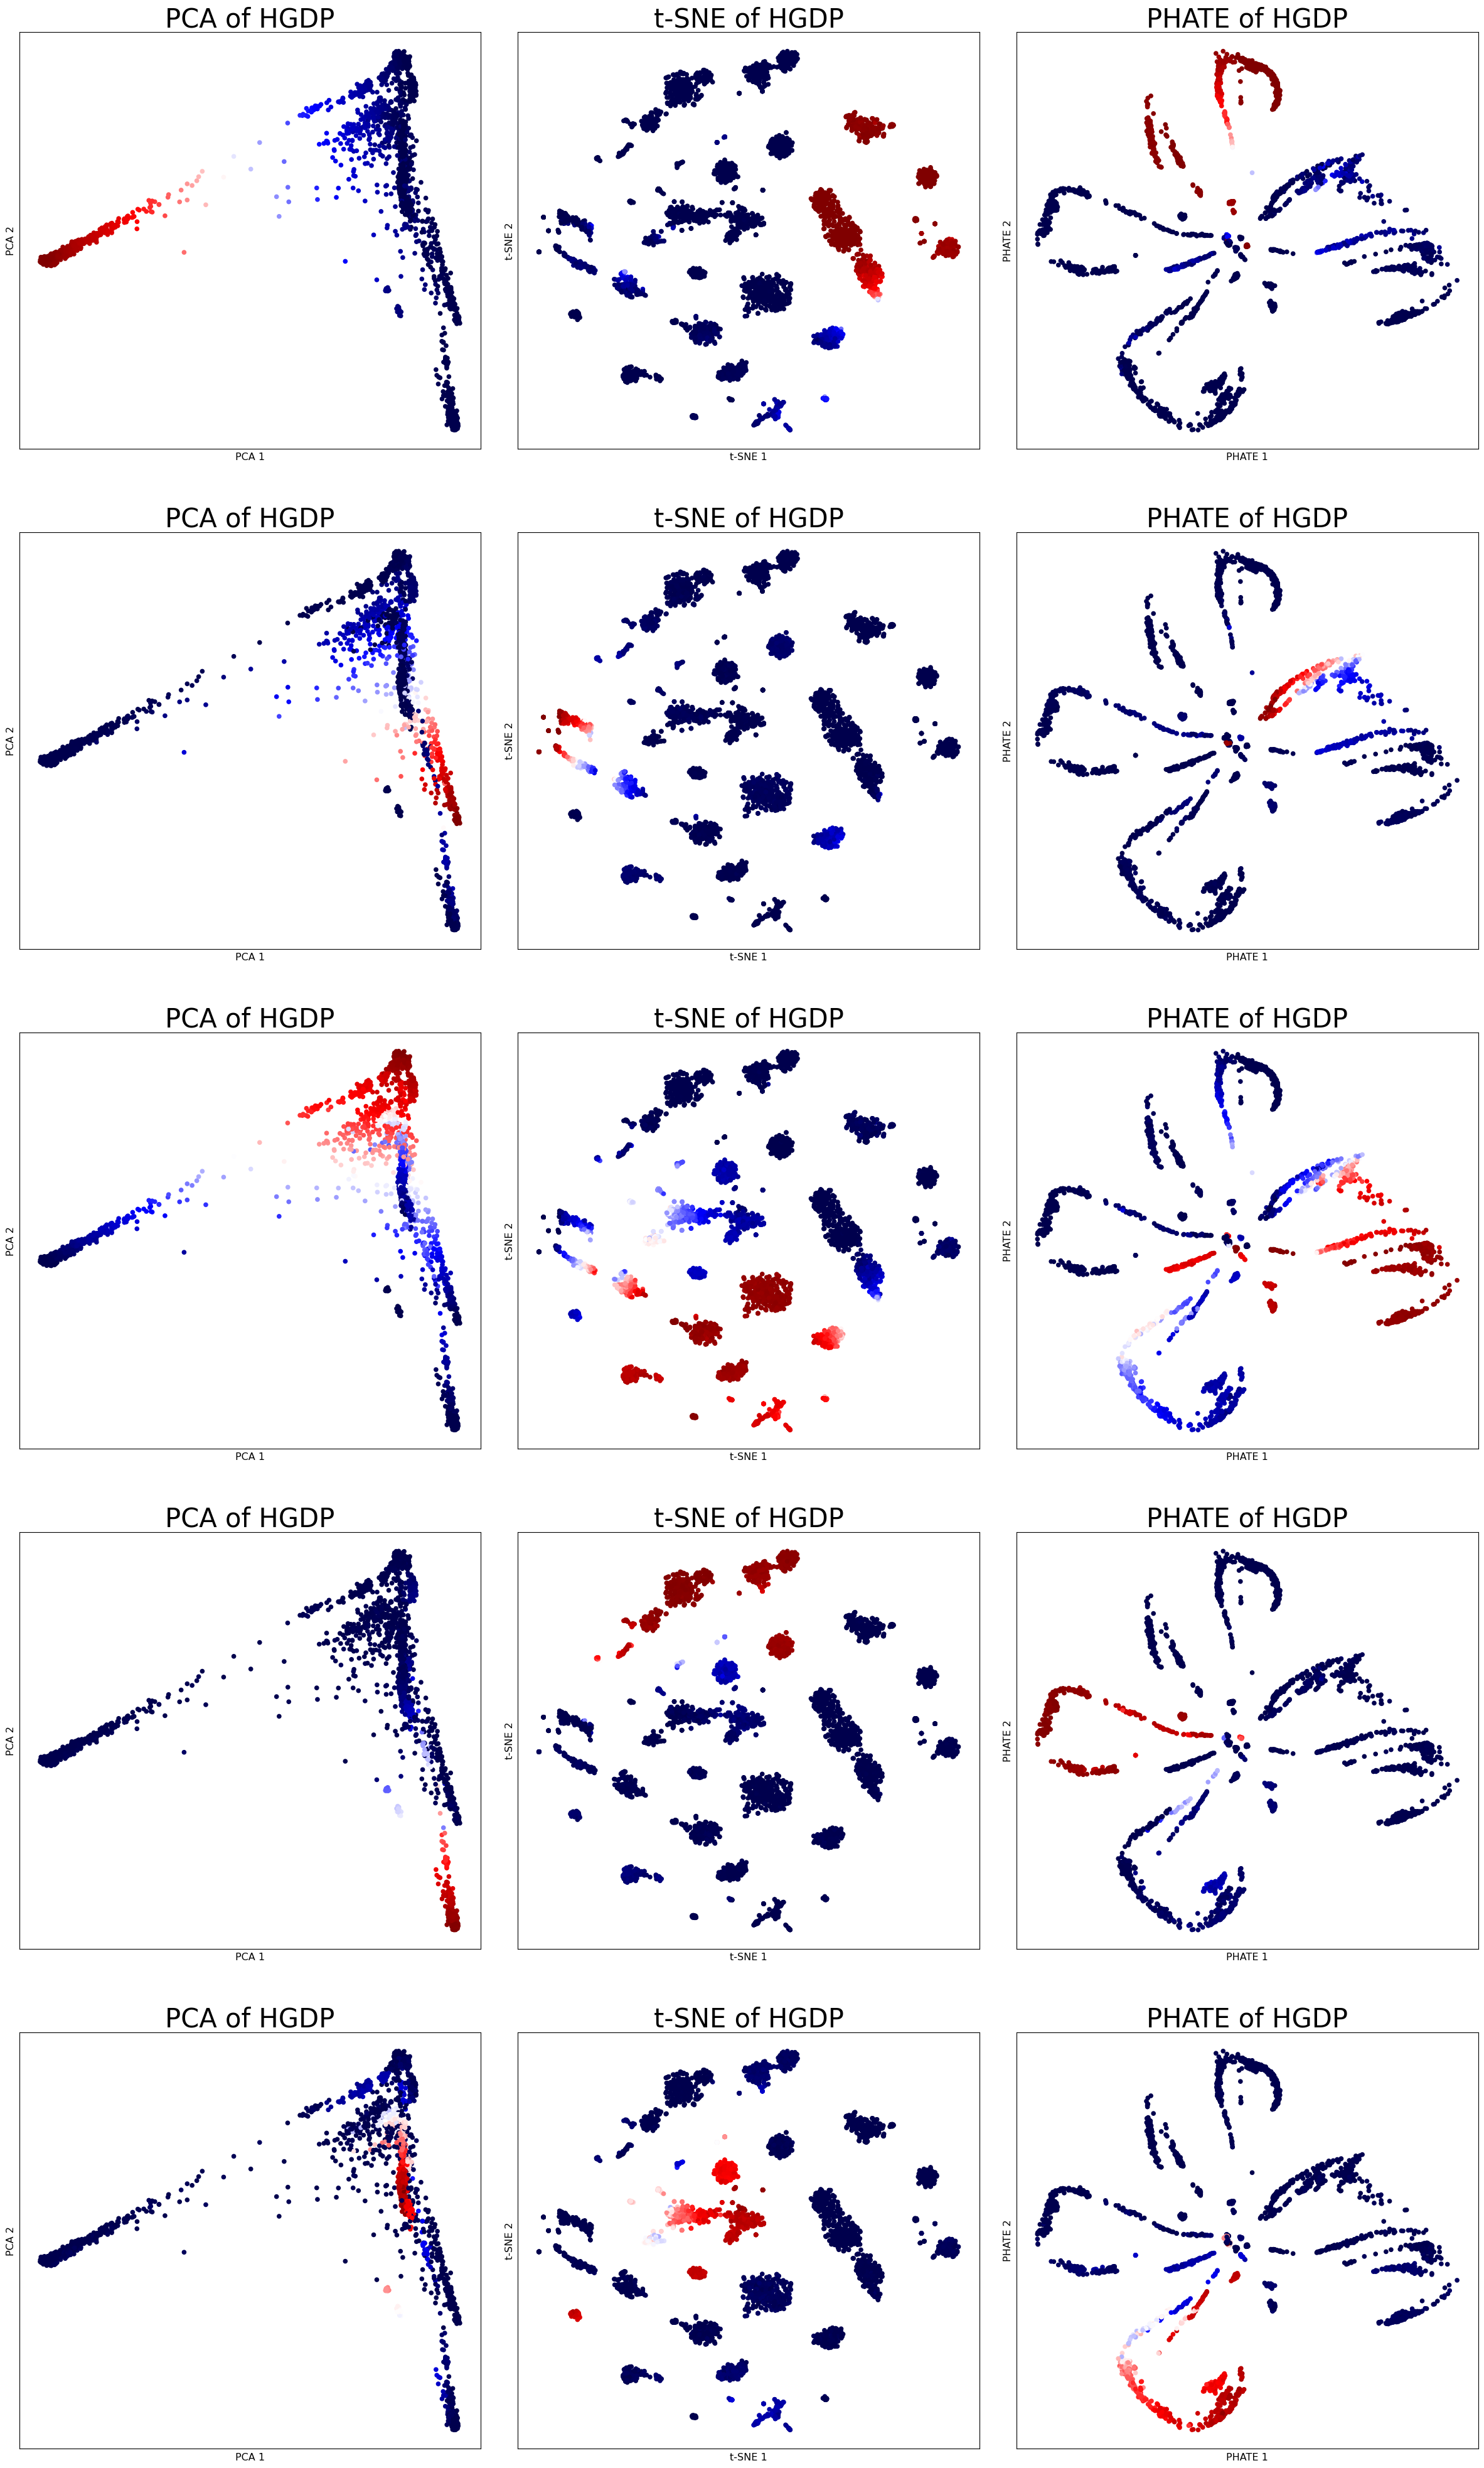

In [11]:
plot_admixtures(pca_emb[index, :2],
                tsne_emb[index], 
                phate_emb[index], 
                admixture_ratios_list[3][index]) # K=5 for visualization

In [12]:
print('PCA (50D): \n' + compute_metrics(pca_emb, 
                                      merged_metadata, 
                                      admixture_ratios_list[3]) + '\n')
print('PCA (2D):  \n' + compute_metrics(pca_emb[:,:2], 
                                     merged_metadata, 
                                     admixture_ratios_list[3]) + '\n')
print('t-SNE:  \n' + compute_metrics(tsne_emb, 
                                  merged_metadata, 
                                  admixture_ratios_list[3]) + '\n')
print('PHATE:  \n' + compute_metrics(phate_emb, 
                                  merged_metadata, 
                                  admixture_ratios_list[3]) + '\n')

PCA (50D): 
   Geo: 0.73. (Medians): 0.73. (only far) 0.65 
 Admix: 0.71. (Medians): 0.86. (only far) 0.61

PCA (2D):  
   Geo: 0.74. (Medians): 0.73. (only far) 0.64 
 Admix: 0.76. (Medians): 0.88. (only far) 0.66

t-SNE:  
   Geo: 0.50. (Medians): 0.61. (only far) 0.34 
 Admix: 0.49. (Medians): 0.73. (only far) 0.35

PHATE:  
   Geo: 0.44. (Medians): 0.27. (only far) 0.28 
 Admix: 0.51. (Medians): 0.32. (only far) 0.40



In [13]:
from sklearn.random_projection import GaussianRandomProjection
projector = GaussianRandomProjection(n_components=2000, random_state=42)
reduced_genotype_matrix = projector.fit_transform(normalized_matrix)
pca_embr, pca_objr = helpers.compute_pca_from_data_matrix(reduced_genotype_matrix,
                                                          to_fit_on,
                                                          to_transform_on,
                                                          n_components=50)
phate_embr = helpers.compute_phate(pca_embr, to_fit_on, to_transform_on, knn=5, t=5)

Running PHATE on 3400 observations and 50 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.43 seconds.
  Calculating affinities...
  Calculated affinities in 0.02 seconds.
Calculated graph and diffusion operator in 0.46 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.17 seconds.
  Calculating KMeans...
  Calculated KMeans in 1.08 seconds.
Calculated landmark operator in 1.99 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.92 seconds.
Calculating metric MDS...
Calculated metric MDS in 3.96 seconds.
Calculating KNN search...
Calculated KNN search in 0.09 seconds.
Calculating affinities...


/lustre06/project/6065672/sciclun4/Envs/phate_env/lib/python3.11/site-packages/phate/phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


In [14]:
tsne_obj2 = TSNE(n_components=2, init='pca')
tsne_embr = np.zeros(shape=(len(pca_embr), 2))
tsne_outr = tsne_obj2.fit_transform(pca_embr[to_fit_on | to_transform_on])
tsne_embr[to_fit_on | to_transform_on] = tsne_outr

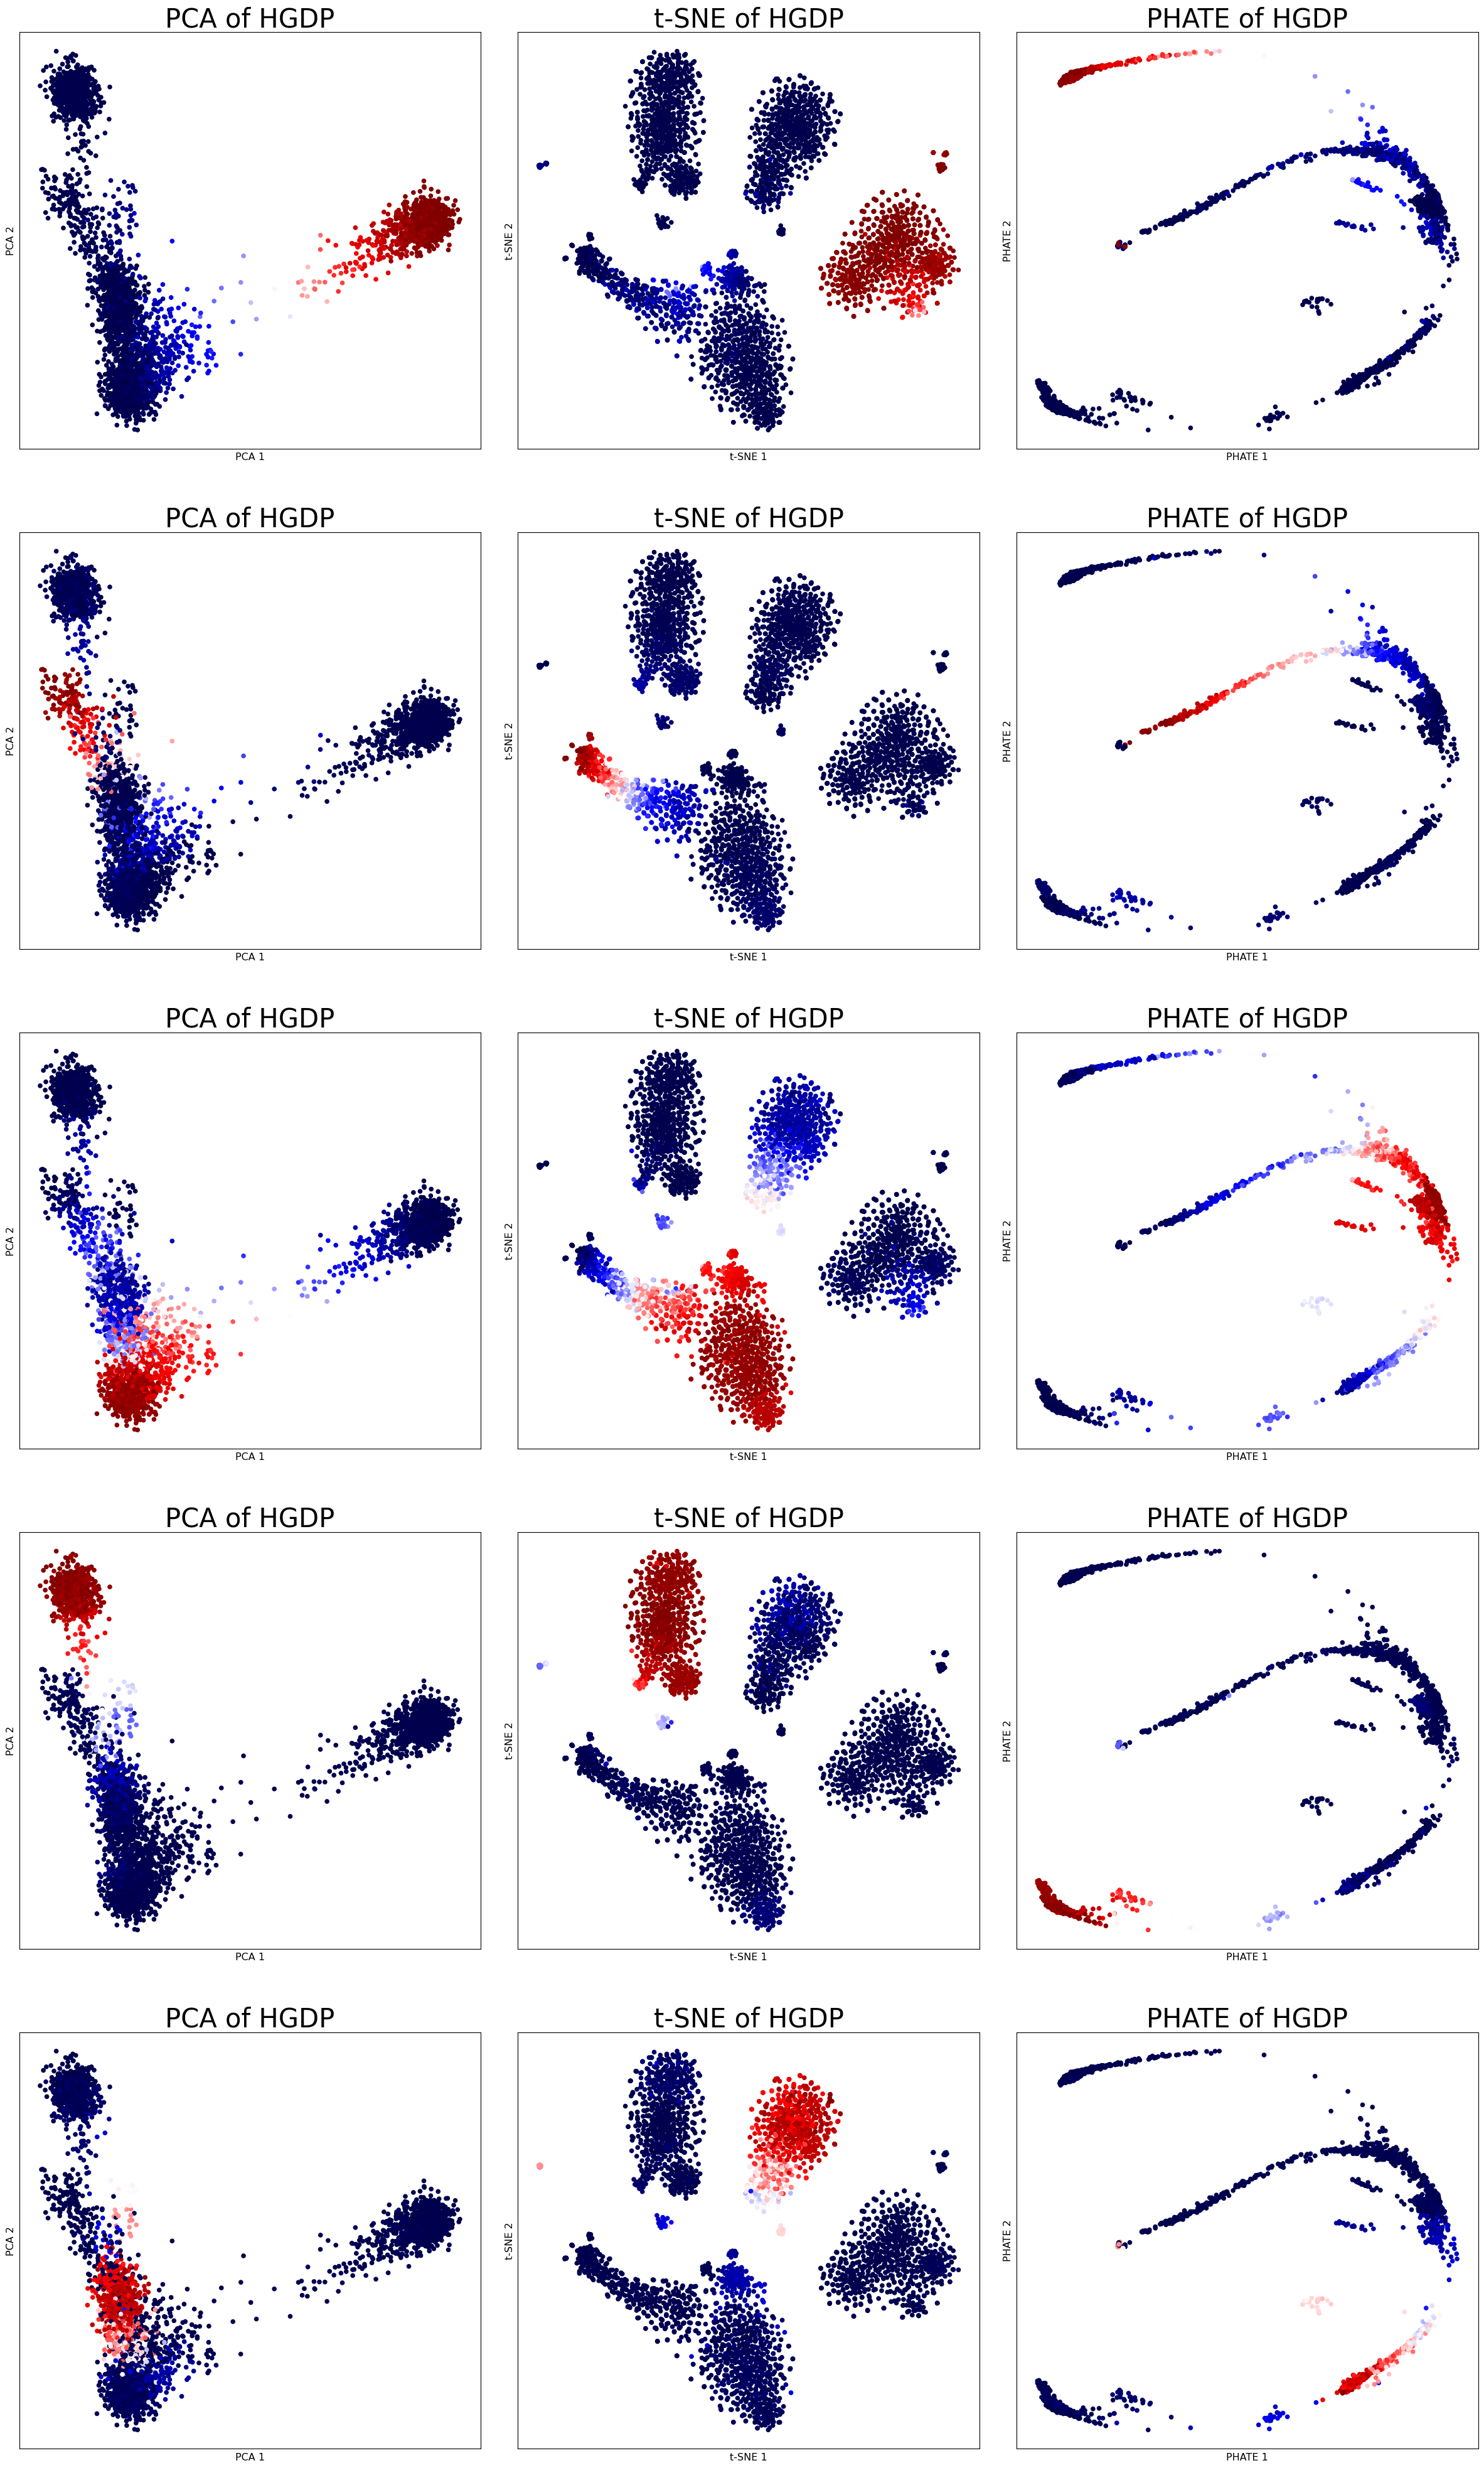

In [15]:
plot_admixtures(pca_embr[index, :2],
                tsne_embr[index], 
                phate_embr[index], 
                admixture_ratios_list[3][index])

In [16]:
print('PCA (50D): \n' + compute_metrics(pca_embr, 
                                      merged_metadata, 
                                      admixture_ratios_list[3]) + '\n')
print('PCA (2D):  \n' + compute_metrics(pca_embr[:,:2], 
                                     merged_metadata, 
                                     admixture_ratios_list[3]) + '\n')
print('t-SNE:  \n' + compute_metrics(tsne_embr, 
                                  merged_metadata, 
                                  admixture_ratios_list[3]) + '\n')
print('PHATE:  \n' + compute_metrics(phate_embr, 
                                  merged_metadata, 
                                  admixture_ratios_list[3]) + '\n')

PCA (50D): 
   Geo: 0.72. (Medians): 0.72. (only far) 0.65 
 Admix: 0.05. (Medians): 0.06. (only far) -0.11

PCA (2D):  
   Geo: 0.73. (Medians): 0.72. (only far) 0.65 
 Admix: 0.75. (Medians): 0.88. (only far) 0.67

t-SNE:  
   Geo: 0.75. (Medians): 0.80. (only far) 0.67 
 Admix: 0.64. (Medians): 0.77. (only far) 0.53

PHATE:  
   Geo: 0.66. (Medians): 0.59. (only far) 0.55 
 Admix: 0.74. (Medians): 0.71. (only far) 0.65



In [17]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def plot_admixture_allcomps(ancestry_coords_list, merged_metadata, admixture_ratios_list, Ks, coord_labels):
    """
    Plot admixture metrics for different ancestry coordinates.

    Parameters:
    - ancestry_coords_list: List of numpy arrays (each num_samples x num_feats).
    - merged_metadata: Metadata DataFrame with filtering information.
    - admixture_ratios_list: List of admixture ratios (each corresponding to ancestry_coords).
    - Ks: List of K values for admixture components.
    """
    # Apply filtering
    to_keep = ~merged_metadata['filter_pca_outlier'] & ~merged_metadata['hard_filtered'] & ~merged_metadata['filter_contaminated']
    merged_metadata = merged_metadata[to_keep]
    
    # Initialize storage for outputs
    results = {'Admixture Preservation': [], 
               'Medians': [], 
               'Far Only': []}
    
    # Iterate over each ancestry_coords
    for ancestry_coords in ancestry_coords_list:
        ancestry_coords = ancestry_coords[to_keep]
        metric_results = {'Admixture Preservation': [], 
                          'Medians': [], 
                          'Far Only': []}
        
        # Compute metrics for each K
        for k, admixture_ratios in tqdm(zip(Ks, admixture_ratios_list), total=len(Ks), desc="Processing Ks"):
            admixture_ratios = admixture_ratios[to_keep]
            admixture_preservation_dists = compute_continental_admixture_metric_dists(ancestry_coords, admixture_ratios, merged_metadata, use_medians=False)
            admixture_preservation_dists_medians = compute_continental_admixture_metric_dists(ancestry_coords, admixture_ratios, merged_metadata, use_medians=True)
            admixture_preservation_dists_far = compute_continental_admixture_metric_dists(ancestry_coords, admixture_ratios, merged_metadata, use_medians=False, only_far=True)
            
            # Store results
            metric_results['Admixture Preservation'].append(admixture_preservation_dists)
            metric_results['Medians'].append(admixture_preservation_dists_medians)
            metric_results['Far Only'].append(admixture_preservation_dists_far)
        
        # Append to overall results
        for key in results:
            results[key].append(metric_results[key])
    
    # Convert results to arrays for easier indexing
    for key in results:
        results[key] = np.array(results[key])

    return results

Processing Ks: 100%|██████████| 8/8 [02:56<00:00, 22.01s/it]


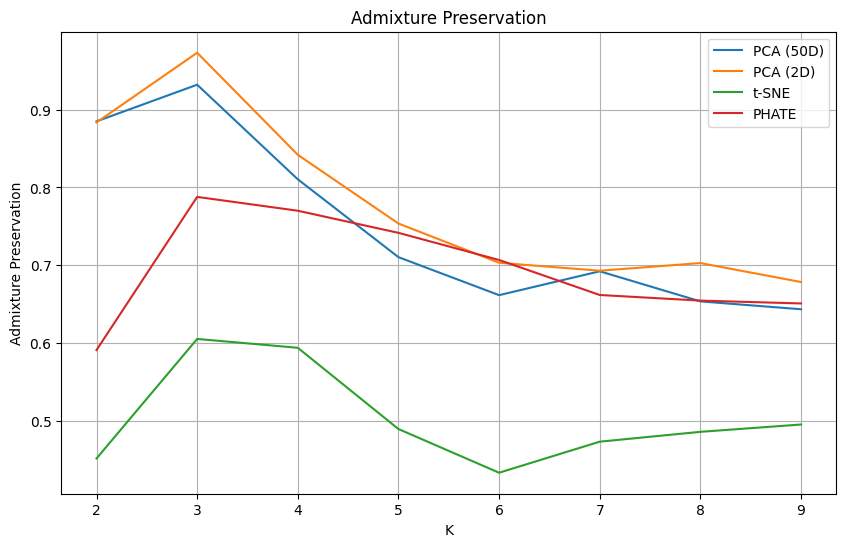

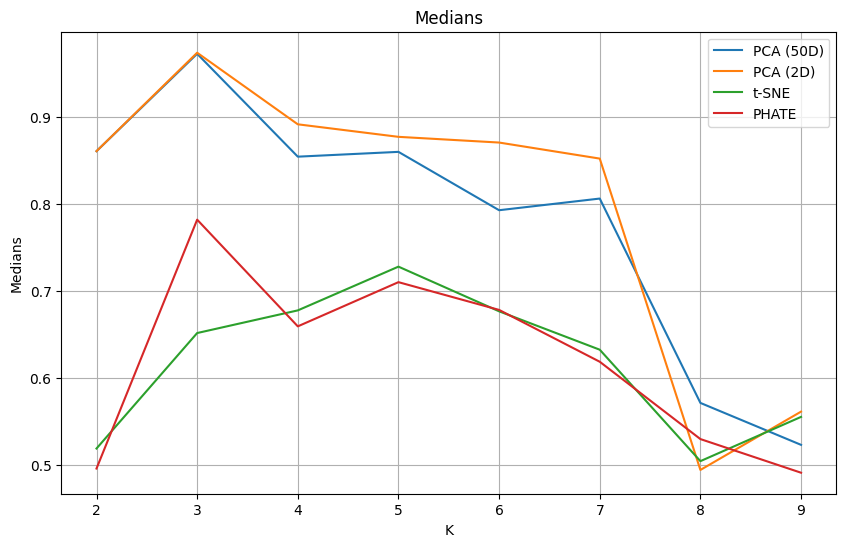

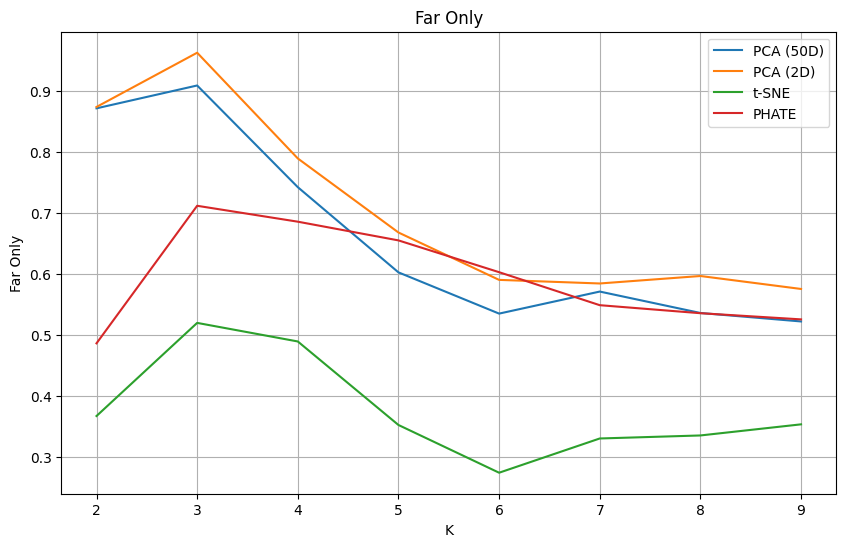

In [18]:
results_df = plot_admixture_allcomps([pca_emb, pca_emb[:,:2], 
                                      tsne_emb, phate_embr], 
                                      merged_metadata, 
                                      admixture_ratios_list, 
                                      [2,3,4,5,6,7,8,9], 
                                     ['PCA (50D)', 'PCA (2D)', 't-SNE', 'PHATE'])

Ks = [2,3,4,5,6,7,8,9]
ls = ['PCA (50D)', 'PCA (2D)', 't-SNE', 'PHATE']

# Plot each metric
for metric_name, metric_data in results_df.items():
    plt.figure(figsize=(10, 6))
    for i, coords in enumerate([pca_emb, pca_emb[:,:2], 
                                      tsne_emb, phate_embr]):
        plt.plot(Ks, metric_data[i], label=ls[i])

    plt.title(metric_name)
    plt.xlabel('K')
    plt.ylabel(metric_name)
    plt.legend(loc='best')
    plt.xticks(Ks)
    plt.grid()
    plt.show()

In [19]:
for i in range(5):
    try:
        print('{} PHATE: '.format(i) + compute_metrics(phate_embr, 
                                          merged_metadata, 
                                          admixture_ratios_list[3][:, i:i+1]))
    except:
        pass

for i in range(4):
    try:
        print('{} t-SNE: '.format(i) + compute_metrics(tsne_embr, 
                                          merged_metadata, 
                                          admixture_ratios_list[3][:, i:i+1]))
    except:
        pass

0 PHATE:    Geo: 0.65. (Medians): 0.59. (only far) 0.55 
 Admix: 0.44. (Medians): 0.32. (only far) 0.44
1 PHATE:    Geo: 0.65. (Medians): 0.59. (only far) 0.54 
 Admix: -0.05. (Medians): -0.09. (only far) -0.09
2 PHATE:    Geo: 0.65. (Medians): 0.59. (only far) 0.54 
 Admix: 0.47. (Medians): 0.59. (only far) 0.44
3 PHATE:    Geo: 0.65. (Medians): 0.59. (only far) 0.54 
 Admix: 0.40. (Medians): 0.41. (only far) 0.44
Graph not connected, even at k=100! Giving up!
Graph not connected, even at k=100! Giving up!
0 t-SNE:    Geo: 0.75. (Medians): 0.80. (only far) 0.67 
 Admix: 0.33. (Medians): 0.43. (only far) 0.33
1 t-SNE:    Geo: 0.75. (Medians): 0.80. (only far) 0.67 
 Admix: 0.18. (Medians): 0.07. (only far) 0.15
2 t-SNE:    Geo: 0.74. (Medians): 0.80. (only far) 0.67 
 Admix: 0.31. (Medians): 0.25. (only far) 0.35
3 t-SNE:    Geo: 0.75. (Medians): 0.80. (only far) 0.66 
 Admix: 0.35. (Medians): 0.26. (only far) 0.34
